In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [2]:
import sunradiation as sun
import weatherfeed as wf
import emoncmsfeed as getfeeds

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

# Modèle 03 



## Téléchargement des données

### Météo

In [457]:
coords_grenoble = (45.1973288, 5.7139923) #(45.1973288, 5.7103223)

startday, lastday = pd.to_datetime('19/06/2017', format='%d/%m/%Y'), pd.to_datetime('now')

In [458]:
# download the data:
weatherdata = wf.buildmultidayDF(startday, lastday, coords_grenoble )

19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 1, 2, 3, 4, 5, done


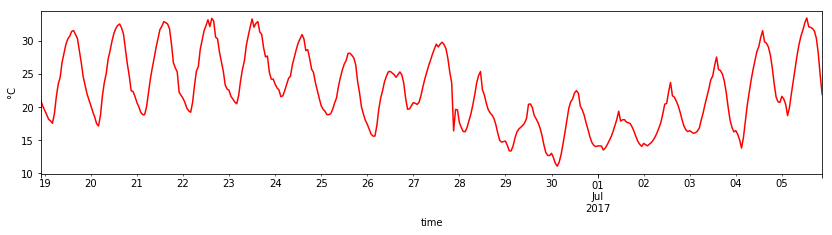

In [459]:
weatherdata['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

### Irradiation solaire

In [460]:
sundata = sun.buildmultidayDF( coords_grenoble, weatherdata.index, cloudCover = weatherdata['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


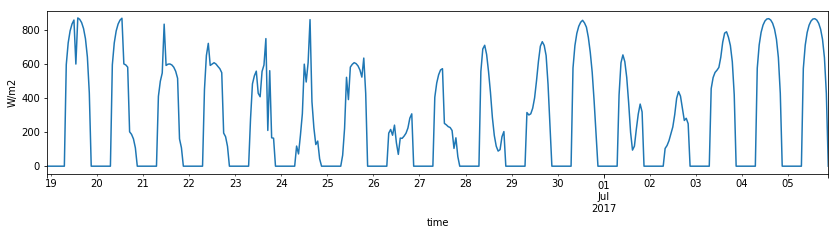

In [461]:
sundata['I0'].plot(figsize=(14, 3));  plt.ylabel('W/m2');

#### Projection sur les surfaces vitrées

In [462]:
sigma = 37  # deg, angle du toit
phi_C = 50  # deg, azimuth du toit

In [587]:
sunFlux_dict = {'flux_bastille':sun.projectDF( 37, 50, sundata ), 
                'flux_cuisine': sun.projectDF( 90, 50, sundata ),
                'flux_vercors': sun.projectDF( 37, 180+50, sundata),
                'flux_chambre': sun.projectDF( 90, 180+50, sundata )}

sunFlux = pd.DataFrame( sunFlux_dict )

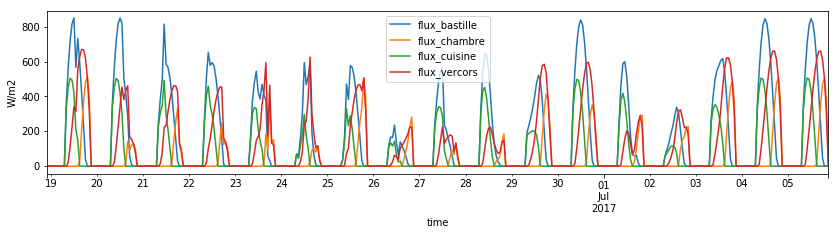

In [464]:
sunFlux.plot(figsize=(14, 3)); plt.ylabel('W/m2');

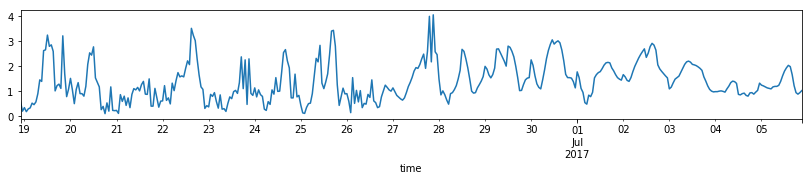

In [465]:
weatherdata['windSpeed'].plot(figsize=(14, 2))

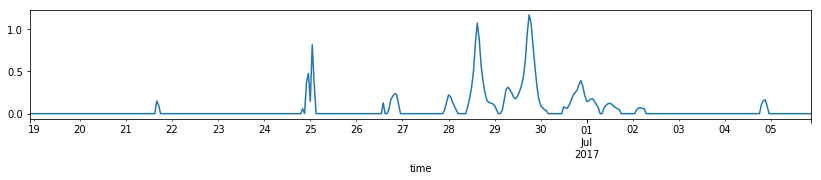

In [586]:
weatherdata['precipIntensity'].plot(figsize=(14, 2))

### Température intérieure mesurée

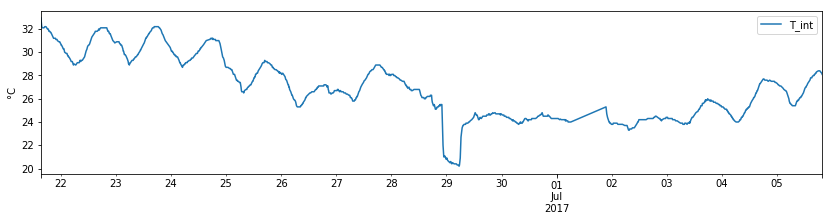

In [584]:
dataframefreq = '10min'
feeds =  { 'T_int': 3 }

Tmesure = getfeeds.builddataframe( feeds, dataframefreq ) # startdate=pd.to_datetime('22/06/2017')
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

## Grandeurs physiques

propriétés double vitrage: https://www.energieplus-lesite.be/index.php?id=10396#c2234

### fenêtres

In [467]:
windows_size = { 'bastille':(1.2, 0.8),
            'cuisine1':(0.3, 0.72),
           'cuisine2':(0.3, 0.72),
            'chambre1':(0.3, 0.72),
            'chambre2':(0.3, 0.72),
            'vercors1':(0.6, 0.8),
            'vercors2':(0.6, 0.8),
            'sdb':(0.25, 0.25)
          }

In [468]:
def get_Ufenetre( largeur, hauteur ):
    k_vitre = 2.8 # W/m2/K
    surface = hauteur * largeur
    U_vitre = surface*k_vitre # W/K

    # https://www.energieplus-lesite.be/index.php?id=17039
    psi = 0.06 # W/m/K
    perimetre = 2*(hauteur + largeur)
    U_chassis = psi*perimetre # W/K

    Ufenetres = U_vitre + U_chassis
    
    return Ufenetres

In [469]:
Ufenetres = sum(  [ get_Ufenetre( *dim ) for dim in windows_size.values() ] )

print('Ufenetres: %.2f W/K'%Ufenetres)

Ufenetres: 9.10 W/K


#### Rayonement

In [470]:
Facteur_g = 0.76 # Facteur solaire (prend en compte l'absorption et la ré-émission)

In [471]:
def surf( k ):
    return windows_size[k][0]*windows_size[k][1]

In [678]:
weatherdata['flux_tot'] =( surf('bastille')*sunFlux_dict['flux_bastille'] \
            + 2*surf('cuisine1')*sunFlux_dict['flux_cuisine'] \
            + 2*surf('chambre1')*sunFlux_dict['flux_chambre']\
            + 2*surf('vercors1')*sunFlux_dict['flux_vercors'] ) * Facteur_g

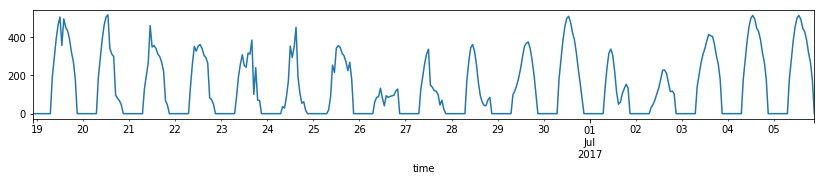

In [679]:
weatherdata['flux_tot'].plot(figsize=(14, 2))

### Masse thermique mur & sol

In [474]:
Ri = 0.13  # coef échange intérieure mur, W/m2/K
S_wall = 58 + 2*22.7 # m2

U_wall = 1/Ri*S_wall

print( 'U_wall= %0.2f W/K' %U_wall )

U_wall= 795.38 W/K


In [611]:
rhoCp = 1400e3 # densité*Capacité thermique, J/m3/K
k = 1.75  #  conductivité, W/m/K

alpha = k/rhoCp # diffusivité, s.m-2

print('temps caractériqtique: %.2f h'%(ep_wall**2/alpha/60/60))


print('epaisseur caractériqtique: %.2f cm'% ( 100*np.sqrt( alpha*24*60*60 ) ))

temps caractériqtique: 55.56 h
epaisseur caractériqtique: 32.86 cm


### Air :

In [612]:
Volume = 22.7*7.94 # m2
rhoCp_air = 1256 # J/m3/K 

Mth_air = rhoCp_air*Volume

In [613]:
taux = 0.2 # Volume / heure
U_aeration = taux * Volume/60/60 * rhoCp_air

In [614]:
print( 'U_aeration= %0.2f W/K' % U_aeration )

U_aeration= 12.58 W/K


In [708]:
coeffs = {}
coeffs['U_ext'] = U_aeration + Ufenetres

coeffs['alpha'] = alpha
coeffs['rhoCp'] = rhoCp

coeffs['h_wall'] = 1/Ri
coeffs['U_wall'] = U_wall


coeffs['dx'] = dx

coeffs['Mth_air'] = Mth_air
coeffs['eta'] = 0.5


coeffs['L'] = 0.08  #m 

In [709]:
print( coeffs )

{'alpha': 1.25e-06, 'dx': 0.045454545454545456, 'U_wall': 795.3846153846154, 'rhoCp': 1400000.0, 'U_ext': 21.672407111111113, 'Mth_air': 226378.92799999999, 'eta': 0.5, 'h_wall': 7.692307692307692, 'L': 0.08}


## Solveur

In [710]:
""" Interpolation des données météo
"""
data_dict = weatherdata.to_dict(orient='list')
time_sec = weatherdata.index.astype(np.int64) // 10e9

def interpoldata( t, key):
    data = np.interp( t, time_sec, data_dict[key] )
    return data

In [711]:
interpoldata( 149859002, 'temperature' )

25.330833333333334

In [712]:
def Laplacien( U, dx=1 ):
    """ Calcul le laplacien du vecteur U
        avec des conditions aux limites adiabatiques 
    """
    d2Udx2 = np.zeros_like( U )
    
    U_i = U[1:-1]
    U_im1 = U[0:-2]
    U_ip1 = U[2:]

    d2Udx2[1:-1] = ( U_ip1 + U_im1 -2*U_i )/dx**2
    
    d2Udx2[0] = -(U[0]-U[1])/dx**2
    d2Udx2[-1] = (U[-2] - U[-1])/dx**2
    
    return d2Udx2

In [713]:
def get_dTdt( T, t, coeffs ):
    
    Tint = T[0]
    Twall = T[1:]

    #weatherdata = interpoldata(  t, 'temperature' )
    T_ext = interpoldata(  t, 'temperature' )
    flux_tot =  coeffs['eta'] * interpoldata(  t, 'flux_tot' )
        
    Uext = Ufenetres + U_aeration
    dTint_dt = 1/coeffs['Mth_air']*( coeffs['U_ext']*( T_ext - Tint ) + \
                           coeffs['U_wall']*( Twall[0] - Tint ) + flux_tot )
    
    dTdt_wall = coeffs['alpha'] *Laplacien( Twall, dx=coeffs['dx'] )

    dTdt_wall[0] += - coeffs['h_wall']*( Twall[0] - Tint )/coeffs['rhoCp']/coeffs['dx'] # rhoCp ?? 
    
    dTdt = np.zeros_like( T )
    dTdt[0] = dTint_dt
    dTdt[1:] = dTdt_wall
    
    return dTdt

In [714]:
from scipy.integrate import odeint

In [715]:
N = 12  # nombre de mailles pour le calcul
X = np.linspace(0, coeffs['L'], N)
dx = coeffs['L']/(N-1)


Tzero = np.ones(N+1) * weatherdata['temperature'].mean()


# Calcul :
res = odeint(get_dTdt, Tzero, time_sec, args=(coeffs, ))

In [716]:
cols = {'T_air':res[:, 0] }
results = pd.DataFrame(  cols, index=weatherdata.index )

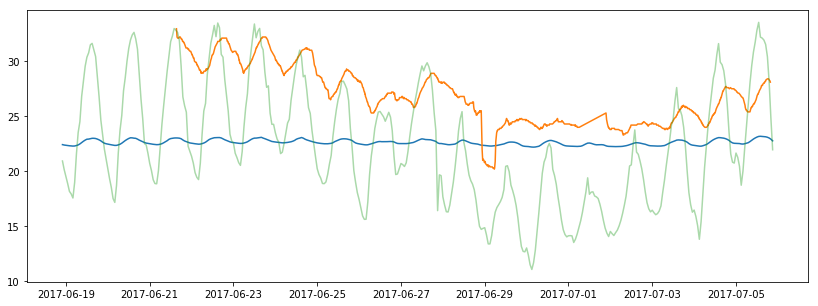

In [717]:
plt.figure( figsize=(14, 5) )
plt.plot(results)
plt.plot(Tmesure)
plt.plot(weatherdata['temperature'], alpha=0.4)

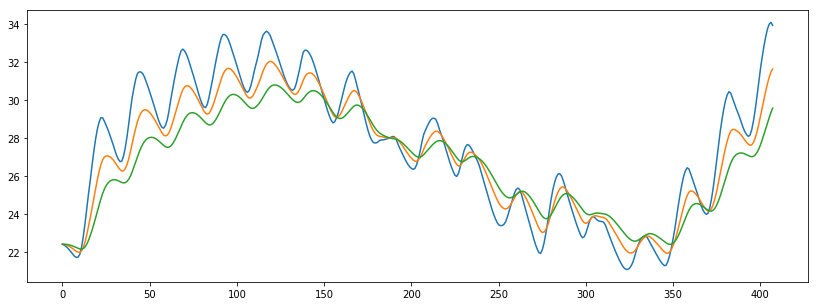

In [625]:
plt.figure( figsize=(14, 5) )
plt.plot( res[:, 1] )
plt.plot( res[:, 2] )
plt.plot( res[:, 3] )

## Avec transformée de Fourier

In [637]:
def model03TF_apply( data_model, U_ext=None, U_wall=None, M_air=None, \
                    eta=None, Sk=None, alpha=None, L=None,  sample_freq=None ):
    """ T_ext : np_array
        sample_freq : duré entre les points, en seconde
    """
    
    data_dict_TF = data_model.to_dict(orient='list')

    T_ext = np.array( data_dict_TF['T_ext'] )
    phi = np.array( data_dict_TF['phi'] )

    # TF (reel)
    TF_ext = np.fft.rfft( T_ext  )
    TF_phi = np.fft.rfft( phi  )
    freq = np.fft.rfftfreq( T_ext.size, d=sample_freq)
    iw = 2j*np.pi*freq
    
    
    # inertie mur 
    #alpha = k/rhoCp # diffusivité, s.m-2
    expL = np.exp( -(1+1j)*np.sqrt( 4*np.pi*freq/alpha  )*L )
    E = (1-expL)/(1+expL)
    
    A = E*(1+1j)*np.sqrt( np.pi*freq/alpha  )
    B = A/( U_wall/Sk + A )
    
    # modele
    source = U_ext*TF_ext + eta*TF_phi
    divide = M_air*iw + U_ext + U_wall*B
    
    TF_theo = source/divide

    # TF inverse
    T_theo = np.fft.irfft( TF_theo , n=T_ext.size )
    
    return pd.DataFrame( {'T_theo':T_theo}, index=data_model.index )

In [638]:
sample_freq = 10*60

data_model = weatherdata[ ['temperature', 'flux_tot'] ].copy()
data_model.rename(columns={'temperature': 'T_ext', 'flux_tot': 'phi'}, inplace=True)

In [639]:
data_model = data_model.resample('10min').interpolate()

In [640]:
coeffs

{'Mth_air': 226378.92799999999,
 'U_ext': 21.672407111111113,
 'U_wall': 795.3846153846154,
 'alpha': 1.25e-06,
 'dx': 0.03125,
 'eta': 0.38,
 'rhoCp': 1400000.0}

In [718]:
params = {'U_ext':21.67, 'U_wall':795.38, 'M_air':226378, 'alpha':1.25e-06, \
                         'eta':0.38, 'Sk':k*S_wall, 'L':0.08, 'sample_freq':sample_freq}

In [719]:
# run
T_theo = model03TF_apply( data_model , **params )
data_model['T_theo'] = T_theo

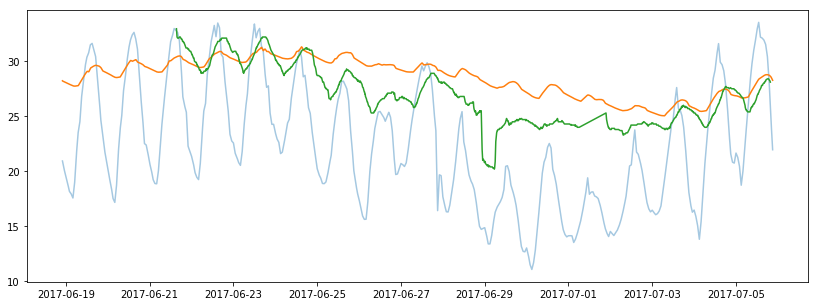

In [720]:
# plot
plt.figure( figsize=(14, 5) )
plt.plot( data_model['T_ext'], alpha=0.4 ) ;
plt.plot( data_model['T_theo'] ) ;
plt.plot( Tmesure['T_int'] ) ;

In [573]:
def errorfit( data_model,  T_int, params ):
    
    T_theo = model03TF_apply( data_model, **params )

    return np.sum( ( T_int - T_theo['T_theo'] )**2 )

In [574]:
errorfit( data_model, Tmesure['T_int'],  params  )

12255.141311551582

In [575]:
from scipy.optimize import fmin

In [576]:
variables =  [ 'eta', 'U_ext'] #, 'U_wall']

v0 = [ params[k] for k in variables  ]

T_int = Tmesure['T_int']

def get_errorfit( args ):
    params_fit = params.copy()

    for i in range( len( variables ) ):
        params_fit[ variables[i] ] = args[i]
        
    return errorfit( data_model,  T_int, params_fit )

In [577]:
v0

[0.35, 46]

In [578]:
var_res = fmin(get_errorfit, v0 )

params_opti = params.copy()
for i in range( len( variables ) ):
    params_opti[ variables[i] ] = var_res[i]
    
print( var_res )

Optimization terminated successfully.
         Current function value: 3794.809897
         Iterations: 56
         Function evaluations: 107
[  0.63879181  46.40339091]


In [579]:
# run
T_theo = model03TF_apply( data_model , **params_opti )
data_model['T_theo'] = T_theo

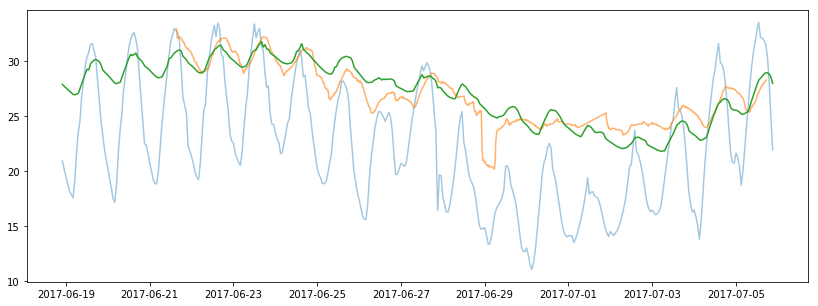

In [580]:
# plot
plt.figure( figsize=(14, 5) )
plt.plot( data_model['T_ext'], alpha=0.4 ) ;
plt.plot( Tmesure['T_int'],  alpha=0.6 ) ;
plt.plot( data_model['T_theo'] ) ;


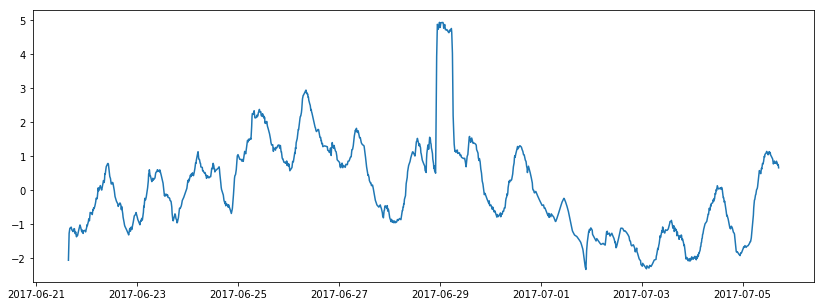

In [568]:
plt.figure( figsize=(14, 5) )

plt.plot( data_model['T_theo']-Tmesure['T_int'] ) ;


# Avec ODE

In [39]:
from scipy.integrate import ode

In [40]:
get_dTdt_ode = lambda t, T:  get_dTdt( T, t )

solveur = ode( get_dTdt_ode ).set_integrator('dopri5')
solveur.set_initial_value(Tzero, t_span[0]) #.set_f_params(2.0).set_jac_params(2.0)

NameError: name 't_span' is not defined

In [ ]:
solveur

In [ ]:
solveur.integrate( t_span[1] )

In [ ]:
for t1 in t_span[1:]:
    if solveur.successful():
        print(solveur.t, solveur.integrate( t1 ))

# Old

In [ ]:
def model02_apply( datarow, colflux=None, disp=False  ):
    flux_soleil = datarow[ colflux ]
    T_air = datarow['temperature']
    h = coef_echange( datarow['windSpeed'] )
    
    emissivite_tuile = 0.92

    rayonement_soleil = (1-albedo_tuile)*flux_soleil
    convection = lambda T: -h * (T - T_air)
    rayonement_toit = lambda T: -sigmaSB*emissivite_tuile*( T + 273 )**4
    #rayonement_ciel =  +sigmaSB*( T_air + 273 )**4  # insert cloud cover here
    rayonement_ciel = Goforth_skyrad( datarow )
    
    somme_flux = lambda T: convection(T) + rayonement_toit(T) + rayonement_soleil + rayonement_ciel
    
    # Resolution numérique, recherche du zéro:
    Tmin, Tmax = -50, 200
    T_eq = brentq(somme_flux, Tmin, Tmax)
    
    if disp:
        print( convection(T_eq), rayonement_toit(T_eq), rayonement_soleil, rayonement_ciel )
    
    return T_eq

In [ ]:
def Goforth_skyrad( datarow ):
    """ Power radiated by the night sky
        see:  https://physics.stackexchange.com/q/153947
        https://physics.stackexchange.com/questions/153839/
        what-is-the-temperature-of-the-clear-night-sky-from-the-surface-of-earth
        "Cloud effects on thermal downwelling sky radiance," AeroSense 2002
    """
    C = datarow['cloudCover']
    K = 0.2 #0.34 for very low clouds to 0.06 for very high clouds,
    T = datarow['temperature'] + 273
    RH = datarow['humidity']*100

    Pthermal = ( 1 + K*C**2 ) * 8.78e-13 * T**5.852 * RH**0.07195
    
    return Pthermal